In [ ]:
# %%bash
# apt-get -q -y install bowtie

In [8]:
from pyfaidx import Sequence
from guido.guides import Guide
from guido.locus import Locus

# seq = "GCCGACCCATTCTGCTGCCCTTCTGTACCGTGGTGCGGCTCTCTCGCTCCACTCCTTAAACACTAGTTTGAACTTATCGGCATCAGTTGCGCACGCGGCTTGATTTAAAATAGCACAGAACTATTGAATTCGTTTCACCAAacacacatacacacacccacatacaAAGATACGGACAGTTACAGTGGTGCGGAAAGTTTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATCAAACATGTTCAGATTATGCAATCGTGAGTATTCGTTGACCACCGCTTGACCTGTGTTAAACATAAATGAATGGAAAGGTAAGGCTTTGAAGGTCACTGCTGCTGGCTGACGGAATTCACAAtttggtttttgatgttttggttttttttttGTATCGAATTTTGAAGTCAGTGAACGTGGCATAACACCATATGCCGCTACCTTCAAGATGCAGATACTCCTAACTTCTCGTGTCTGAGCTAGCTAA"
seq = "TTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATCAAACATGTTCAGATTATGCAATCGTGAGTATTCGTTGACCACCGCTTGACCTGTGT"
l = Locus(sequence=seq, name='AgamP4_2R', start=48714554, end=48714654)
locus.find_guides()
locus.guides

[gRNA-1(CGCAATACCACCCGTCAGAGTGG|AgamP4_2R:48714561-48714584|-|),
 gRNA-2(TTATCATCCACTCTGACGGGTGG|AgamP4_2R:48714554-48714577|+|),
 gRNA-3(TCTGAACATGTTTGATGGCGTGG|AgamP4_2R:48714589-48714612|-|),
 gRNA-4(CATAATCTGAACATGTTTGATGG|AgamP4_2R:48714594-48714617|-|)]

In [26]:
from guido.genome import Genome, load_genome_from_file

G = Genome('AgamP4.12', genome_file_abspath='tests/data/AgamP4.fa', annotation_file_abspath='tests/data/AgamP4.12.gtf')
G.build(3,bowtie_path='bin/bowtie/')

Indexing genome annotation.
Building Bowtie index
Done: /Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12
AgamP4.12 genome data can now be used by Guido: /Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12.guido


In [3]:
G.__dict__

{'genome_name': 'AgamP4.12',
 '_bowtie_ignore': False,
 'bowtie_index': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12'),
 'genome_file_abspath': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.fa'),
 'annotation_file_abspath': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12.gtf'),
 'annotation_sorted_gz_file': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12.gtf.gz'),
 'tbi_file': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12.gtf.tbi'),
 'fai_file': PosixPath('/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.fa.fai')}

In [3]:
import zarr
import numpy as np
import pandas as pd
import allel
import h5py
import itertools
import multiprocessing as mp
from functools import partial
# from ete3 import Tree
import dask.array as da
import dask.dataframe as dd
import scipy

import h5py
import numpy as np

from guido.genome import Genome, load_genome_from_file
from guido.locus import locus_from_coordinates, locus_from_gene
from guido.helpers import guides_to_dataframe

# %run /Users/nace/imperial/conservation/_load_zarr_plots.py

# 2R:48712946-48716859
# chromosome, start, end = "2R", 48715300, 48717267
chromosome, start, end = "2R", 48714553, 48714651
AgamP4 = load_genome_from_file(guido_file='tests/data/AgamP4.12.guido')

l = locus_from_coordinates(AgamP4, chromosome, start, end)

# l = locus_from_gene(genome=AgamP4, gene_name='AGAP011477')
l.find_guides(min_flanking_length=0, selected_features={'all'})
l.simulate_end_joining()

l.find_off_targets(external_genome=None, 
                core_length=10,
                core_mismatches=1,
                total_mismatches=4,
                bowtie_path='bin/bowtie/')

with h5py.File('/Users/nace/imperial/conservation/data/AgamP4_conservation.h5', mode='r+') as data_h5:
    snp_density = data_h5[l.chromosome]['snp_density'][0,l.start-1:l.end-1]
    phylop =      data_h5[l.chromosome]['phyloP'][0,l.start-1:l.end-1]
    cs =          data_h5[l.chromosome]['Cs'][0,l.start-1:l.end-1]

z = zarr.open('/Users/nace/imperial/VC_ot/G3.gd.zarr', mode='r')

variants = z[l.chromosome]["variants"]
calldata = z[l.chromosome]["calldata"]
pos = allel.SortedIndex(variants["POS"])

# loc = pos.locate_range(l.start, l.end)
# g = allel.GenotypeArray(calldata["GT"][loc])
# ac = np.zeros(shape=(l.end-l.start,4))
# af = np.zeros(shape=(l.end-l.start,4))
# vseq = np.empty(shape=(l.end-l.start,4), dtype="<U1")

# ac[pos[loc] - l.start,:] = np.array(g.count_alleles(max_allele=3))
# af[pos[loc] - l.start,:] = np.array(g.count_alleles(max_allele=3).to_frequencies())
# vseq[pos[loc] - l.start,0] = np.array(variants["REF"][loc])
# vseq[pos[loc] - l.start,1:] = np.array(variants["ALT"][loc])

# l.add_layer('g3_ac', ac.T[1:,:].sum(axis=0))
# l.add_layer('g3_af', af.T[1:,:].sum(axis=0))
# # l.add_layer('g3_vseq', vseq)

# # l.add_layer('snp_density', np.array(snp_density))
# # l.add_layer('phylop', np.array(phylop))
l.add_layer('cs', layer_data=np.array(cs))
# # l.add_layer('accessibility', np.array(ac))

ranks = l.rank_guides(rank_layer_names=['cs', 'mmej_sum_score', 'mmej_of_score', 'ot_sum_score'], is_benefit_layer=[True, True, True, False])


In [7]:
pd.DataFrame([g.__dict__ for g in l.guides])

,locus_seq,guide_seq,guide_pam,guide_chrom,guide_start,guide_end,guide_strand,relative_cut_pos,absolute_cut_pos,rank_score,rank,id,mmej_patterns,off_targets,_layers,mmej_sum_score,mmej_oof_score,ot_sum_score,cs
0,TTTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATC...,CGCAATACCACCCGTCAGAGTGG,TGG,2R,48714561,48714584,-,14,48714567,0.066950,4,gRNA-1,"[{'left': 'TTTATCATCC----', 'left_seq': 'TTTAT...","[{'ix': 0, 'mismatches': {21: 'A', 18: 'A', 9:...","{'mmej_sum_score': 809.8999999999999, 'mmej_oo...",809.9,72.552167,1,0.446189
1,TTTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATC...,TTATCATCCACTCTGACGGGTGG,TGG,2R,48714554,48714577,+,18,48714571,0.352648,2,gRNA-2,"[{'left': 'TTTATCATCCACTC----', 'left_seq': 'T...","[{'ix': 1, 'mismatches': {21: 'G', 17: 'G', 10...","{'mmej_sum_score': 884.0, 'mmej_oof_score': 10...",884.0,100.000000,3,0.482574
2,TTTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATC...,TCTGAACATGTTTGATGGCGTGG,TGG,2R,48714589,48714612,-,42,48714595,0.181072,3,gRNA-3,[{'left': 'TTTATCATCCACTCTGACGGGTGGTATTGCGCAAC...,"[{'ix': 2, 'mismatches': {21: 'C', 19: 'G', 6:...","{'mmej_sum_score': 1013.6999999999999, 'mmej_o...",1013.7,62.493834,1,0.560826
3,TTTATCATCCACTCTGACGGGTGGTATTGCGCAACTCCACGCCATC...,CATAATCTGAACATGTTTGATGG,TGG,2R,48714594,48714617,-,47,48714600,0.893691,1,gRNA-4,[{'left': 'TTTATCATCCACTCTGACGGGTGGTATTGCGCAAC...,"[{'ix': 3, 'mismatches': {21: 'A', 8: 'C', 7: ...","{'mmej_sum_score': 1141.3999999999999, 'mmej_o...",1141.4,83.458910,8,0.595581


In [8]:
import numpy as np

guides = []

for g in l.guides:
    g = g.__dict__
    for lk, lv in g['_layers'].items():
        if isinstance(lv, np.ndarray):
            g[lk] = lv.mean()
        else:
            g[lk] = lv
    guides.append(g)


In [10]:
gdf = pd.DataFrame(guides)

gdf = gdf.drop(['mmej_patterns', 'off_targets', '_layers'], axis=1)
gdf
gdf.to_csv('/Users/nace/imperial/guides/results/silvia_dsx_e5.csv')

In [18]:
import zarr
import numpy as np
import pandas as pd
import allel

z = zarr.open('/Users/nace/imperial/ignacio_vc/dataset/AgamP4_2L.zarr', mode='r')
G = allel.Genotypes(z['call_genotype'])
pos = allel.SortedIndex(z['variant_position'])



In [4]:
for g in l.guides[:10]:
    print(g)


gRNA-1(AACGACGACGTTAAGCGTGCCGG|2L:44994108-44994131|+|)
gRNA-2(GCTTCTACACTCGCTTCTTCCGG|2L:44994127-44994150|-|)
gRNA-3(AGAAGCGAGTGTAGAAGCGCAGG|2L:44994132-44994155|+|)
gRNA-4(CATGACGAACACAGCACAGACGG|2L:44994165-44994188|+|)
gRNA-5(GTACTTGTAGTAGTAGTGATCGG|2L:44994190-44994213|-|)
gRNA-6(CTCAAGCTGAGGTGTGGTAGTGG|2L:44994218-44994241|-|)
gRNA-7(AGATAGCTCAAGCTGAGGTGTGG|2L:44994224-44994247|-|)
gRNA-8(GCAGTAGATAGCTCAAGCTGAGG|2L:44994229-44994252|-|)
gRNA-9(TACTGCTGAAGAAAGCACAACGG|2L:44994246-44994269|+|)
gRNA-10(TGCTGAAGAAAGCACAACGGAGG|2L:44994249-44994272|+|)


In [2]:
from guido.locus import _prepare_annotation

x = _prepare_annotation(AgamP4.annotation_file_abspath)

In [4]:
# start = l.start
# end = l.end
# chromosome = l.chromosome

chromosome, start, end = "2L", 44994091, 44994571

x
# x.query(
#         f"(Chromosome == '{chromosome}') &  \
#         (((Start >= {start - 1}) & (Start <= {end + 1})) | \
#         ((End >= {start - 1}) & (End <= {end + 1})))"
# )

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,exon_number
0,2L,VectorBase,gene,203778,205293,.,+,.,AGAP004678,NaN,NaN
1,2L,VectorBase,transcript,203778,205293,.,+,.,AGAP004678,AGAP004678-RA,NaN
2,2L,VectorBase,exon,203778,203924,.,+,.,AGAP004678,AGAP004678-RA,1
3,2L,VectorBase,CDS,203865,203924,.,+,0,AGAP004678,AGAP004678-RA,1
4,2L,VectorBase,start_codon,203865,203868,.,+,0,AGAP004678,AGAP004678-RA,1
...,...,...,...,...,...,...,...,...,...,...,...
225398,Y_unplaced,VectorBase,CDS,26422,26563,.,-,0,AGAP029221,AGAP029221-RA,3
225399,Y_unplaced,VectorBase,stop_codon,26419,26422,.,-,0,AGAP029221,AGAP029221-RA,3
225400,Y_unplaced,VectorBase,five_prime_utr,27020,27106,.,-,.,AGAP029221,AGAP029221-RA,NaN
225401,Y_unplaced,VectorBase,five_prime_utr,26752,26932,.,-,.,AGAP029221,AGAP029221-RA,NaN


In [17]:
import pyranges

x = pyranges.read_gtf(AgamP4.annotation_file_abspath, as_df=False)
a = x.intersect(pyranges.PyRanges(chromosomes=[chromosome], starts=[start], ends=[end]))

a.df.rename(columns={"gene_id": "ID", "exon_number": "Exon"}, inplace=True)

In [9]:
l.layer('cs')[l.guide(0).guide_start - l.start:l.guide(0).guide_start - l.start + 24]

# l.guide(0).guide_start - l.start

array([0.6768356 , 0.6768356 , 0.18866222, 0.28695124, 0.25984788,
       0.6791203 , 0.598631  , 0.6795911 , 0.18929903, 0.6791203 ,
       0.6795911 , 0.1998153 , 0.2887192 , 0.26129276, 0.2893202 ,
       0.6795911 , 0.2701325 , 0.1460883 , 0.26332432, 0.5969937 ,
       0.30364934, 0.68419427, 0.684738  , 0.15354982], dtype=float32)

In [4]:
l.guide(1).layer('mmej_sum_score')

1013.6999999999999

In [19]:
a = np.array([1, 2, 3])

funct = np.max

funct(a)

3

In [10]:
np.array([[1, 2, 0], [3, 4, 0]]).shape

(2, 3)

In [2]:

# accessibility = h5py.File('/Users/nace/imperial/conservation/data/accessibility.h5', mode='r')
# ac = accessibility[l.chromosome]['is_accessible'][start-1:end-1]

# with h5py.File('/Users/nace/imperial/conservation/data/AgamP4_conservation.h5', mode='r+') as data_h5:
#     snp_density = data_h5[l.chromosome]['snp_density'][0,l.start-1:l.end-1]
#     phylop =      data_h5[l.chromosome]['phyloP'][0,l.start-1:l.end-1]
#     cs =          data_h5[l.chromosome]['Cs'][0,l.start-1:l.end-1]

# z = zarr.open('/Users/nace/imperial/VC_ot/G3.gd.zarr', mode='r')

# l.add_layer('snp_density', np.array(snp_density))
# l.add_layer('phylop', np.array(phylop))
# l.add_layer('cs', np.array(cs))
# l.add_layer('accessibility', np.array(ac))

In [33]:
z = zarr.open('/Users/nace/imperial/ignacio_vc/dataset/AgamP4_2R.zarr', mode='r')

l = locus_from_coordinates(AgamP4, '2R', 13241907, 13242018)
l.find_guides(min_flanking_length=0)

In [41]:
calldata = z["call_genotype"]
pos = allel.SortedIndex(z["variant_position"])
g = allel.GenotypeArray(z["call_genotype"])


In [42]:
def pam_snp_alleles(self, guide, gt):
    if guide.strand == "-":
        pam_snp = [v["ac"] if v["pos_rel"] < 2 else 0 for v in g["variants"]]
    else:
        pam_snp = [
            v["ac"] if v["pos_rel"] > len(v["guide_seq"]) - 2 else 0
            for v in g["variants"]
        ]

    return sum(pam_snp)

<GenotypeArray shape=(1648337, 18, 2) dtype=int8>
0/1 0/1 ./. ./. ./. ... ./. ./. ./. ./. ./.
1/1 1/1 ./. ./. ./. ... ./. ./. ./. ./. ./.
./. ./. ./. ./. ./. ... ./. ./. ./. ./. ./.
...
./. ./. ./. ./. ./. ... ./. ./. ./. ./. 1/1
./. ./. ./. ./. ./. ... ./. ./. ./. ./. 1/1
./. ./. ./. ./. ./. ... ./. ./. ./. ./. 1/1

In [43]:
guide = l.guide(1)

for guide in l.guides:
    
    print(guide.guide_start, guide.guide_end)
    
    try:
        guide_loc = pos.locate_range(guide.guide_start, guide.guide_end)    
        print(g[guide_loc])
    except:
        print('no var')


13241934 13241957
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241937 13241960
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241942 13241965
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241934 13241957
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241935 13241958
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241947 13241970
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241947 13241970
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241948 13241971
0/1 0/0 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241962 13241985
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.
1/1 1/1 1/1 1/1 1/1 ... ./. ./. ./. ./. ./.

13241985 13242008
no var
13241990 13242013
no var
13241991 13242014
no var


/Users/nace/imperial/conservation/_load_zarr_plots.py:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([humanize.intcomma(int(x)) for x in ax.get_xticks()])


(0.7, 3.5)

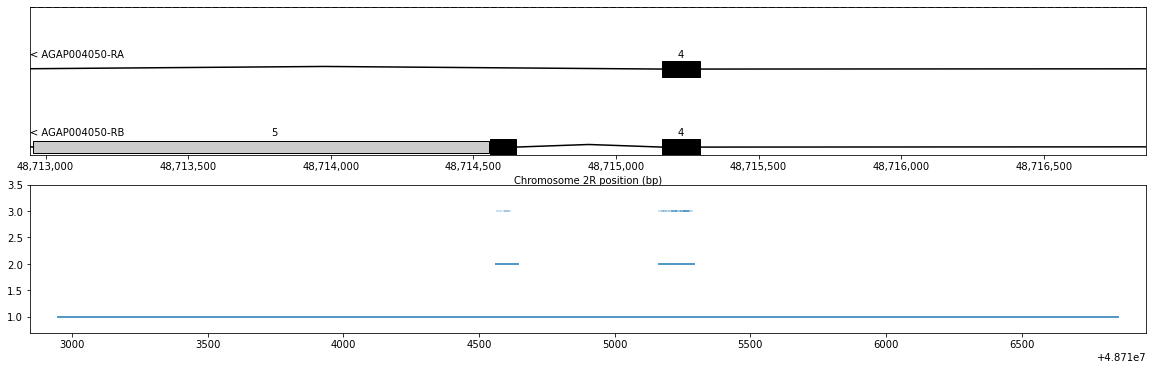

In [3]:
import matplotlib.pyplot as plt

ig, (ax, bx) = plt.subplots(2, figsize=(20, 6))

plot_transcripts(geneset_agam, l.chromosome, l.start, l.end, label_codons=False, label_exons=True, ax=ax)

bx.hlines(y=1, xmin=l.start, xmax=l.end)
for i in l.intervals:
    bx.hlines(y=2, xmin=i[0], xmax=i[1])
for g in l.guides:
    bx.hlines(y=3, xmin=g.guide_start, xmax=g.guide_end, alpha=.3)

bx.set_xlim(l.start-100, l.end+100)
bx.set_ylim(0.7, 3.5)

In [5]:
l.guides

[Guide(CGCAATACCACCCGTCAGAGTGG|2R:48714561-48714584|-|),
 Guide(TCTGAACATGTTTGATGGCGTGG|2R:48714589-48714612|-|),
 Guide(CATAATCTGAACATGTTTGATGG|2R:48714594-48714617|-|),
 Guide(GCACACCAGCGGATCGACGAAGG|2R:48715160-48715183|-|),
 Guide(ATGTACAAAAAGCACACCAGCGG|2R:48715171-48715194|-|),
 Guide(TGCTTTTTGTACATCGCCATCGG|2R:48715180-48715203|+|),
 Guide(GTCATACTAAAGAGCGCCGATGG|2R:48715196-48715219|-|),
 Guide(TCTTTAGTATGACGTACATCAGG|2R:48715206-48715229|+|),
 Guide(CTTTAGTATGACGTACATCAGGG|2R:48715207-48715230|+|),
 Guide(TTTAGTATGACGTACATCAGGGG|2R:48715208-48715231|+|),
 Guide(ATCAGGGGCATCATCTCCCACGG|2R:48715223-48715246|+|),
 Guide(TCAGGGGCATCATCTCCCACGGG|2R:48715224-48715247|+|),
 Guide(GGAGAAACTCGGCTACCCGTGGG|2R:48715239-48715262|-|),
 Guide(TGGAGAAACTCGGCTACCCGTGG|2R:48715240-48715263|-|),
 Guide(CAATGGCTGTTGGAGAAACTCGG|2R:48715250-48715273|-|),
 Guide(GAAGCGAGCCCAATGGCTGTTGG|2R:48715260-48715283|-|),
 Guide(CGAGTTTCTCCAACAGCCATTGG|2R:48715251-48715274|+|),
 Guide(GAGTTTCTCCAACAGCCATTGGG|

In [15]:
features = {'exon', 'three_prime_utr'}

l.annotation.query(f"(Feature in @features) & \
(Chromosome == @l.chromosome) &  \
(((Start >= @l.start) & (Start <= @l.end)) | \
((End >= @l.start) & (End <= @l.end)))")

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,ID,transcript_id,Exon
106527,2R,VectorBase,exon,48715160,48715295,.,-,.,AGAP004050,AGAP004050-RA,4
106544,2R,VectorBase,exon,48715160,48715295,.,-,.,AGAP004050,AGAP004050-RB,4
106546,2R,VectorBase,exon,48712956,48714648,.,-,.,AGAP004050,AGAP004050-RB,5
106553,2R,VectorBase,three_prime_utr,48712956,48714556,.,-,.,AGAP004050,AGAP004050-RB,NaN


In [12]:
'''
track name="ItemRGBDemo" description="Item RGB demonstration" itemRgb="On" 
chr7  127471196  127472363  Pos1  0  +  127471196  127472363  255,0,0
chr7  127472363  127473530  Pos2  0  +  127472363  127473530  255,0,0
chr7  127473530  127474697  Pos3  0  +  127473530  127474697  255,0,0
chr7  127474697  127475864  Pos4  0  +  127474697  127475864  255,0,0
chr7  127475864  127477031  Neg1  0  -  127475864  127477031  0,0,255
'''
with open('/Users/nace/imperial/guide_tool/guido_dash/guido_dash/static/data/guides.bed', 'w') as f:
    for g in l.guides:
        if g.guide_strand == '+': color = '76,201,240'
        else: color = '247,37,133'
        f.write(f"{g.guide_chrom}\t{g.guide_start}\t{g.guide_end}\t{g.guide_seq}\t0\t{g.guide_strand}\t{g.guide_start}\t{g.guide_end}\t{color}\n")

In [3]:
import pyranges
ann_db = pyranges.read_gtf("/Users/nace/imperial/guide_tool/guido/tests/data/AgamP4.12.gtf", as_df=True)
ann_db.rename(columns={"gene_id": "ID", "exon_number": "Exon"}, inplace=True)

ann_db.to_csv('/Users/nace/imperial/guide_tool/guido_dash/static/AgamP4.12.csv')

In [4]:
import string, random

''.join(random.choice(string.ascii_letters) for i in range(12))

'qgEfBpzLxnbx'

In [ ]:
def seq_to_colours(seq):
    
    colours_dict = {
        'A': 'ncl_red', 
        'C': 'ncl_blue',
        'G': 'ncl_orange',
        'T': 'ncl_green',
        'N': 'ncl_white',
        '-': 'ncl_white',
    }

    sequence = []
    for n in seq:
        sequence.append() 
    
seq_to_colours('AGCT')

In [25]:
a = np.array([[[5, 10, -2, -2],
              [-1, -84, -2, -2]],
    
             [[6, 11, -2, -2],
              [-1, -85, -2, -2]]])

a.shape

(2, 2, 4)

In [26]:
mask = a[:,:,:]

In [29]:
a.reshape([-1, 4]).sum(axis=1) > 0

array([ True, False,  True, False])